<a href="https://colab.research.google.com/github/BasitSal1m/PlantVillage-Dataset--PD-C---Assignment-1/blob/main/PlantVillage(PDC).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install kaggle

In [2]:
from google.colab import files

# Upload your Kaggle API key (kaggle.json) that you download from your Kaggle account
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [3]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/

In [4]:
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d abdallahalidev/plantvillage-dataset

100% 2.04G/2.04G [00:24<00:00, 73.1MB/s]
100% 2.04G/2.04G [00:24<00:00, 89.1MB/s]


In [6]:
!unzip -q plantvillage-dataset.zip -d /content/

In [7]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models, optimizers

In [8]:
data_dir = '/content/plantvillage dataset/color'

In [9]:
classes = os.listdir(data_dir)[:19]

In [10]:
# Create train, test, and validation directories
train_dir = '/content/train'
test_dir = '/content/test'
val_dir = '/content/val'

In [11]:
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

In [12]:
# Split the dataset into train, test, and validation sets
for cls in classes:
    cls_path = os.path.join(data_dir, cls)
    train_cls, test_val_cls = train_test_split(os.listdir(cls_path), test_size=0.3, random_state=42)
    test_cls, val_cls = train_test_split(test_val_cls, test_size=0.5, random_state=42)

    os.makedirs(os.path.join(train_dir, cls), exist_ok=True)
    os.makedirs(os.path.join(test_dir, cls), exist_ok=True)
    os.makedirs(os.path.join(val_dir, cls), exist_ok=True)

    for img in train_cls:
        os.replace(os.path.join(cls_path, img), os.path.join(train_dir, cls, img))

    for img in test_cls:
        os.replace(os.path.join(cls_path, img), os.path.join(test_dir, cls, img))

    for img in val_cls:
        os.replace(os.path.join(cls_path, img), os.path.join(val_dir, cls, img))

In [13]:
# Image data generators with augmentation for training set
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

In [14]:
# Validation and test set generators without augmentation
val_test_datagen = ImageDataGenerator(rescale=1./255)

In [15]:
# Image data generators flow_from_directory
batch_size = 32
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 15614 images belonging to 19 classes.


In [16]:
val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 3356 images belonging to 19 classes.


In [17]:
test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 3349 images belonging to 19 classes.


In [18]:
# Define the model (VGG16 in this case)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

model = models.Sequential()
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(len(classes), activation='softmax'))


58889256/58889256 [==============================] - 0s 0us/step


In [19]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
epochs = 10
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=val_generator,
    validation_steps=val_generator.samples // batch_size
)

Epoch 1/10
487/487 [==============================] - 315s 599ms/step - loss: 2.1052 - accuracy: 0.3648 - val_loss: 1.6856 - val_accuracy: 0.5117
Epoch 2/10
487/487 [==============================] - 283s 581ms/step - loss: 1.2454 - accuracy: 0.6081 - val_loss: 0.8305 - val_accuracy: 0.7314
Epoch 3/10
487/487 [==============================] - 283s 580ms/step - loss: 0.9747 - accuracy: 0.6866 - val_loss: 0.8248 - val_accuracy: 0.7239
Epoch 4/10
487/487 [==============================] - 285s 584ms/step - loss: 0.8413 - accuracy: 0.7291 - val_loss: 0.6893 - val_accuracy: 0.7620
Epoch 5/10
487/487 [==============================] - 274s 562ms/step - loss: 0.7446 - accuracy: 0.7605 - val_loss: 0.6709 - val_accuracy: 0.7840
Epoch 6/10
487/487 [==============================] - 285s 584ms/step - loss: 0.6591 - accuracy: 0.7826 - val_loss: 0.4921 - val_accuracy: 0.8389
Epoch 7/10
487/487 [==============================] - 275s 564ms/step - loss: 0.5793 - accuracy: 0.8137 - val_loss: 0.6451 -

In [20]:
# Output directory
output_dir = '/content/output'
os.makedirs(output_dir, exist_ok=True)

In [34]:
# Save the model
model.save(os.path.join(output_dir, 'plantvillage_model.h5'))

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


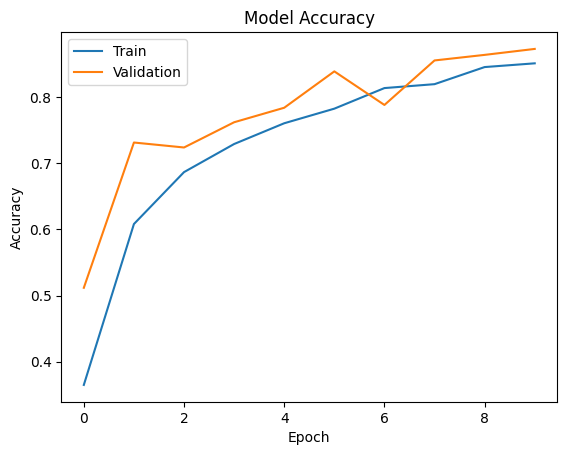

In [22]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig(os.path.join(output_dir, 'accuracy_graph.png'))
plt.show()

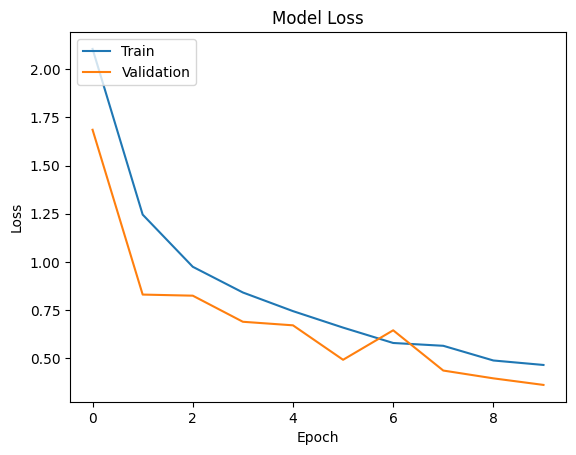

In [23]:
# Plot training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig(os.path.join(output_dir, 'loss_graph.png'))
plt.show()

In [24]:
# Evaluate the model on test set
test_loss, test_acc = model.evaluate(test_generator, steps=test_generator.samples // batch_size)
print(f'Test Accuracy: {test_acc}')


104/104 [==============================] - 13s 122ms/step - loss: 0.3162 - accuracy: 0.8927
Test Accuracy: 0.8927283883094788


In [25]:
# Predictions on test set
predictions = model.predict(test_generator, steps=test_generator.samples // batch_size)
predicted_classes = np.argmax(predictions, axis=1)

104/104 [==============================] - 13s 124ms/step


In [26]:

# True labels
true_labels = []

for i in range(test_generator.samples // batch_size):
    _, batch_labels = next(test_generator)
    true_labels.extend(np.argmax(batch_labels, axis=1))

# Convert to numpy array
true_labels = np.array(true_labels)

In [ ]:
#Tesiting1
if len(true_labels) != len(predicted_classes):
    print("Lengths of true_labels and predicted_classes do not match. Debugging information:")
    print("Length of true_labels:", len(true_labels))
    print("Length of predicted_classes:", len(predicted_classes))

# If lengths match, proceed with the classification report
else:
    # Classification report
    class_report = classification_report(true_labels, predicted_classes, target_names=classes)
    print(class_report)

Lengths of true_labels and predicted_classes do not match. Debugging information:
Length of true_labels: 4381
Length of predicted_classes: 4352


In [ ]:
#testing 2
predictions = model.predict(test_generator, steps=test_generator.samples // batch_size)
print("Shape of predictions:", predictions.shape)

136/136 [==============================] - 15s 110ms/step
Shape of predictions: (4352, 19)


In [ ]:
#tesing 3
print("Length of test generator:", len(test_generator))

Length of test generator: 137


In [ ]:
#testing 4
predictions = model.predict(test_generator, steps=np.ceil(test_generator.samples / batch_size))
print("Shape of predictions:", predictions.shape)

137/137 [==============================] - 18s 133ms/step
Shape of predictions: (4381, 19)


In [27]:
# Check if lengths match before generating classification report
print(len(true_labels), len(predicted_classes))

3328 3328


In [28]:
# Classification report
class_report = classification_report(true_labels, predicted_classes, target_names=classes)
print(class_report)

                                            precision    recall  f1-score   support

Grape___Leaf_blight_(Isariopsis_Leaf_Spot)       0.87      0.76      0.81        94
  Cherry_(including_sour)___Powdery_mildew       0.84      0.94      0.89        93
                        Apple___Apple_scab       1.00      0.61      0.76        41
                     Potato___Early_blight       0.97      0.91      0.94       158
                   Tomato___Bacterial_spot       1.00      0.93      0.97       148
                      Tomato___Target_Spot       1.00      0.99      1.00       174
                  Apple___Cedar_apple_rust       0.98      0.96      0.97       161
                           Grape___healthy       0.98      0.94      0.96        63
                        Tomato___Leaf_Mold       0.80      0.75      0.77       150
             Pepper,_bell___Bacterial_spot       0.80      0.97      0.87       150
                          Tomato___healthy       0.80      0.52      0.63  

In [29]:
# Confusion Matrix for test set
conf_matrix = confusion_matrix(true_labels, predicted_classes)
print(conf_matrix)


[[ 71   7   0   0   0   0   0   0   3   1   0   0   2   6   2   2   0   0
    0]
 [  1  87   0   0   0   0   0   0   2   1   0   0   0   0   2   0   0   0
    0]
 [  2   0  25   2   0   0   0   0   0   0   0   0   9   0   3   0   0   0
    0]
 [  0   1   0 144   0   0   0   0   1   0   2   2   0   1   1   0   5   0
    1]
 [  2   0   0   0 138   0   0   0   0   1   0   0   5   0   1   0   1   0
    0]
 [  0   0   0   0   0 173   0   0   0   1   0   0   0   0   0   0   0   0
    0]
 [  0   0   0   0   0   0 155   1   2   2   0   0   0   0   0   0   1   0
    0]
 [  1   0   0   0   0   0   0  59   0   0   0   0   0   0   3   0   0   0
    0]
 [  1   3   0   0   0   0   0   0 113  19   0   0   0   0   9   4   1   0
    0]
 [  0   0   0   0   0   0   0   0   3 145   0   0   0   0   1   1   0   0
    0]
 [  1   0   0   0   0   0   0   0   7   1  12   0   0   0   0   2   0   0
    0]
 [  0   0   0   0   0   0   0   0   0   0   1  51   0   0   2   2   0   0
    0]
 [  1   0   0   1   0   0   

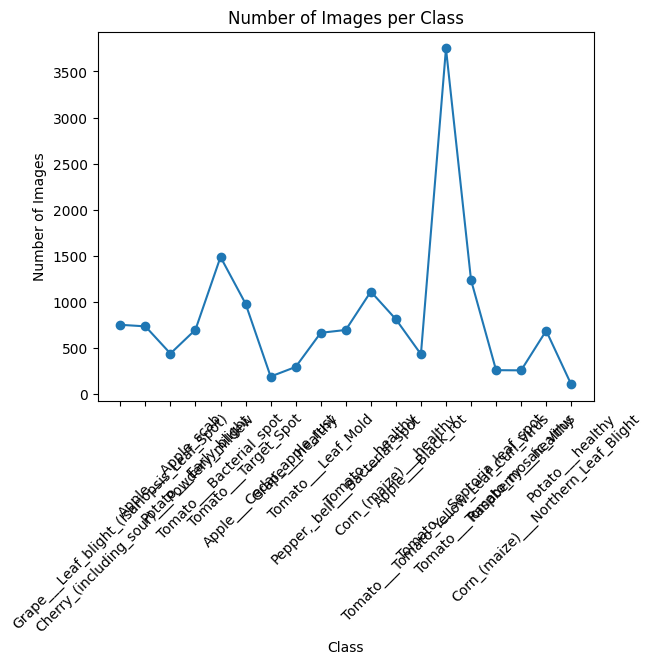

In [30]:
# Line plot graph for the number of images per class
num_images_per_class = [len(os.listdir(os.path.join(train_dir, cls))) for cls in classes]
plt.plot(classes, num_images_per_class, marker='o')
plt.title('Number of Images per Class')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.savefig(os.path.join(output_dir, 'images_per_class.png'))
plt.show()

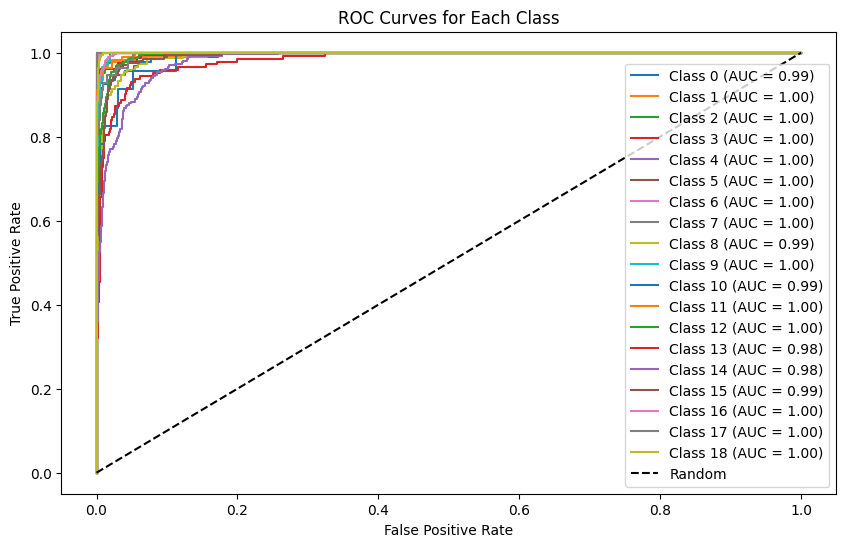

Class 0 - AUC: 0.99413, Error Rate: 0.01112
Class 1 - AUC: 0.99733, Error Rate: 0.00541
Class 2 - AUC: 0.99898, Error Rate: 0.00541
Class 3 - AUC: 0.99760, Error Rate: 0.00661
Class 4 - AUC: 0.99999, Error Rate: 0.00361
Class 5 - AUC: 1.00000, Error Rate: 0.00030
Class 6 - AUC: 0.99989, Error Rate: 0.00240
Class 7 - AUC: 0.99996, Error Rate: 0.00180
Class 8 - AUC: 0.99179, Error Rate: 0.01953
Class 9 - AUC: 0.99856, Error Rate: 0.00962
Class 10 - AUC: 0.98907, Error Rate: 0.00481
Class 11 - AUC: 0.99823, Error Rate: 0.00240
Class 12 - AUC: 0.99550, Error Rate: 0.02374
Class 13 - AUC: 0.98270, Error Rate: 0.02314
Class 14 - AUC: 0.98220, Error Rate: 0.03666
Class 15 - AUC: 0.99274, Error Rate: 0.02314
Class 16 - AUC: 0.99886, Error Rate: 0.01863
Class 17 - AUC: 0.99650, Error Rate: 0.00541
Class 18 - AUC: 0.99962, Error Rate: 0.00511


In [31]:
from sklearn.metrics import roc_curve, auc

# Initialize variables for ROC curves and AUC
fpr = dict()
tpr = dict()
roc_auc = dict()
error_rates = []

# Get predictions for each class
for i in range(len(classes)):
    # True labels for the current class
    true_labels_class = (true_labels == i).astype(int)

    # Predictions for the current class
    predictions_class = predictions[:, i]

    # Ensure both arrays have the same length
    min_len = min(len(true_labels_class), len(predictions_class))
    true_labels_class = true_labels_class[:min_len]
    predictions_class = predictions_class[:min_len]

    # Check if there are samples for the current class
    if np.sum(true_labels_class) > 0 and np.sum(1 - true_labels_class) > 0:
        # Compute ROC curve and AUC
        fpr[i], tpr[i], _ = roc_curve(true_labels_class, predictions_class)
        roc_auc[i] = auc(fpr[i], tpr[i])

        # Append error rate for the current class
        error_rate = np.sum(np.abs(true_labels_class - (predictions_class > 0.5).astype(int))) / len(true_labels_class)
        error_rates.append(error_rate)
    else:
        print(f'Class {i} - AUC and Error Rate not available')

        # Set AUC and error rate to NaN
        roc_auc[i] = np.nan
        error_rates.append(np.nan)

# Plot ROC curves
plt.figure(figsize=(10, 6))
for i in range(len(classes)):
    if i in fpr and i in tpr:
        plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc.get(i, "N/A"):.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='black', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Each Class')
plt.legend()
plt.show()

# Print AUC and error rates for each class
for i in range(len(classes)):
    print(f'Class {i} - AUC: {roc_auc.get(i, "N/A"):.5f}, Error Rate: {error_rates[i]:.5f}')



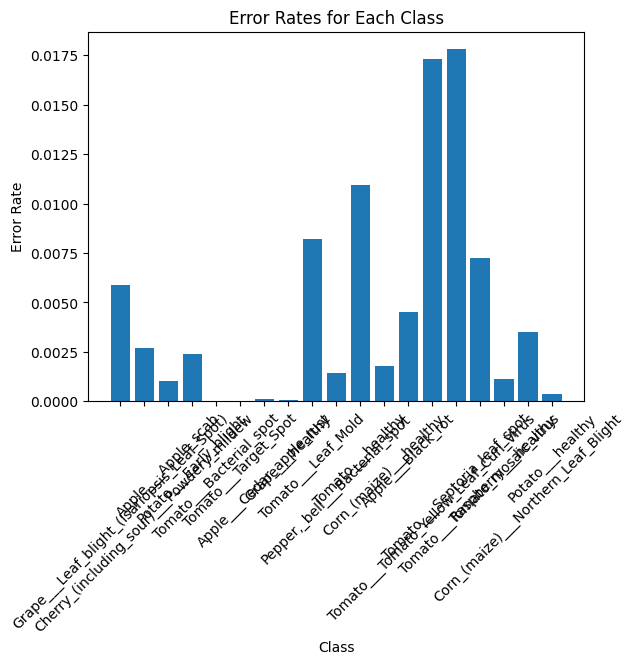

In [32]:
# Error rates for each class
error_rates = 1 - np.array([roc_auc[i] for i in range(len(classes))])
plt.bar(classes, error_rates)
plt.title('Error Rates for Each Class')
plt.xlabel('Class')
plt.ylabel('Error Rate')
plt.xticks(rotation=45)
plt.savefig(os.path.join(output_dir, 'error_rates.png'))
plt.show()

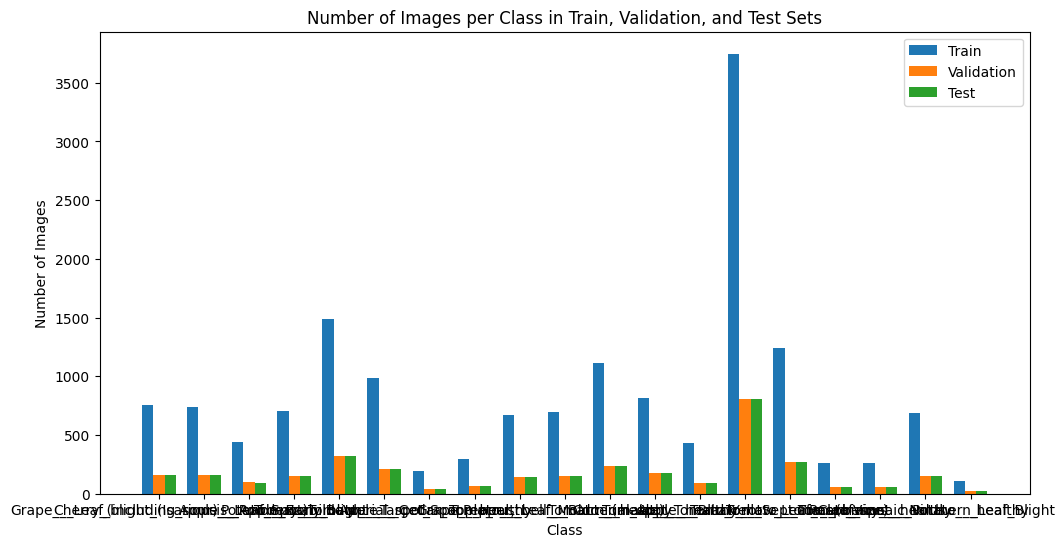

In [33]:
#Calculate image counts graph
# Number of images per class in each dataset (train, validation, test)
num_images_train = [len(os.listdir(os.path.join(train_dir, cls))) for cls in classes]
num_images_val = [len(os.listdir(os.path.join(val_dir, cls))) for cls in classes]
num_images_test = [len(os.listdir(os.path.join(test_dir, cls))) for cls in classes]

# Plot the number of images per class for each dataset
bar_width = 0.25
index = np.arange(len(classes))

plt.figure(figsize=(12, 6))
plt.bar(index, num_images_train, width=bar_width, label='Train')
plt.bar(index + bar_width, num_images_val, width=bar_width, label='Validation')
plt.bar(index + 2 * bar_width, num_images_test, width=bar_width, label='Test')

plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Number of Images per Class in Train, Validation, and Test Sets')
plt.xticks(index + bar_width, classes)
plt.legend()
plt.show()